# Parallel partial GP Regression

## Introduction

Parallel partial Gaussian Process regression, introduced in [this paper](https://projecteuclid.org/journals/annals-of-applied-statistics/volume-10/issue-3/Parallel-partial-Gaussian-process-emulation-for-computer-models-with-massive/10.1214/16-AOAS934.pdf), is a simplification of [Multitask Gaussian Process regression](./Multitask_GP_Regression.ipynb), where intertask similarities are not explicitly learned. The advantage of this approach is that it leads to significant computational savings when the number of outputs (tasks) is large. The difference with [Batch-independent Gaussian Process regression](./Batch_Independent_Multioutput_GP.ipynb) is that a single kernel is learned for all outputs simultaneously.

Given inputs $x$ and $x'$, and tasks $i$ and $j$, the covariance between two datapoints and two tasks is given by

$$  k([x, i], [x', j]) = k_\text{inputs}(x, x') * \delta_{i, j}
$$

where $k_\text{inputs}$ is a standard kernel that operates on the input data, and $\delta_{i, j}$ is the Kronecker delta (i.e., it is 1 if $i = j$ and 0 otherwise).

In [1]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Set up training data

In the next cell, we set up the training data for this example. We'll be using 100 regularly spaced points on [0, 1] as input data. We evaluate 4 sinusoidal functions (two sine and two cosine functions with different periods) on the input data, and add Gaussian noise to get the output data.

In [2]:
train_x = torch.linspace(0, 1, 100)

train_y = torch.stack([
    torch.sin(train_x * (2 * math.pi)) + torch.randn(train_x.size()) * 0.2,
    torch.cos(train_x * (2 * math.pi)) + torch.randn(train_x.size()) * 0.2,
    torch.sin(train_x * math.pi) + torch.randn(train_x.size()) * 0.2,
    torch.cos(train_x * math.pi) + torch.randn(train_x.size()) * 0.2,
], -1)

## Define a parallel partial model

The model should be somewhat similar to the `ExactGP` model in the [simple regression example](../01_Exact_GPs/Simple_GP_Regression.ipynb).
The differences:

1. We're going to wrap ConstantMean with a `MultitaskMean`. This makes sure we have a mean function for each task.
2. Rather than just using an `RBFKernel`, we're using that in conjunction with a `ParallelPartialKernel`. This gives us the covariance function described in the introduction.
3. We're using a `MultitaskMultivariateNormal` and `MultitaskGaussianLikelihood`. This allows us to deal with the predictions/outputs in a nice way. For example, when we call MultitaskMultivariateNormal.mean, we get a `n x num_tasks` matrix back.

You may also notice that we don't use a `ScaleKernel`, since the `ParallelPartialKernel` will do some scaling for us. (This way we're not overparameterizing the kernel.)

In [3]:
class ParallelPartialGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ParallelPartialGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.MultitaskMean(
            gpytorch.means.ZeroMean(), num_tasks=train_y.shape[1]
        )
        self.covar_module = gpytorch.kernels.ParallelPartialKernel(
            gpytorch.kernels.RBFKernel(), num_tasks=train_y.shape[1]
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultitaskMultivariateNormal(mean_x, covar_x)

likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=train_y.shape[1])
model = ParallelPartialGPModel(train_x, train_y, likelihood)

### Train the model hyperparameters

In [4]:
# this is for running the notebook in our testing framework
import os
smoke_test = ('CI' in os.environ)
training_iterations = 2 if smoke_test else 50


# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iterations):
    optimizer.zero_grad()
    output = model(train_x)
    loss = -mll(output, train_y)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f' % (i + 1, training_iterations, loss.item()))
    optimizer.step()

Iter 1/50 - Loss: 1.185
Iter 2/50 - Loss: 1.149
Iter 3/50 - Loss: 1.113
Iter 4/50 - Loss: 1.075
Iter 5/50 - Loss: 1.036
Iter 6/50 - Loss: 0.997
Iter 7/50 - Loss: 0.957
Iter 8/50 - Loss: 0.917
Iter 9/50 - Loss: 0.877
Iter 10/50 - Loss: 0.837
Iter 11/50 - Loss: 0.798
Iter 12/50 - Loss: 0.759
Iter 13/50 - Loss: 0.721
Iter 14/50 - Loss: 0.682
Iter 15/50 - Loss: 0.644
Iter 16/50 - Loss: 0.605
Iter 17/50 - Loss: 0.566
Iter 18/50 - Loss: 0.527
Iter 19/50 - Loss: 0.488
Iter 20/50 - Loss: 0.449
Iter 21/50 - Loss: 0.410
Iter 22/50 - Loss: 0.372
Iter 23/50 - Loss: 0.334
Iter 24/50 - Loss: 0.298
Iter 25/50 - Loss: 0.263
Iter 26/50 - Loss: 0.230
Iter 27/50 - Loss: 0.198
Iter 28/50 - Loss: 0.168
Iter 29/50 - Loss: 0.139
Iter 30/50 - Loss: 0.112
Iter 31/50 - Loss: 0.086
Iter 32/50 - Loss: 0.063
Iter 33/50 - Loss: 0.042
Iter 34/50 - Loss: 0.023
Iter 35/50 - Loss: 0.007
Iter 36/50 - Loss: -0.006
Iter 37/50 - Loss: -0.016
Iter 38/50 - Loss: -0.024
Iter 39/50 - Loss: -0.030
Iter 40/50 - Loss: -0.034
Iter

### Make predictions with the model

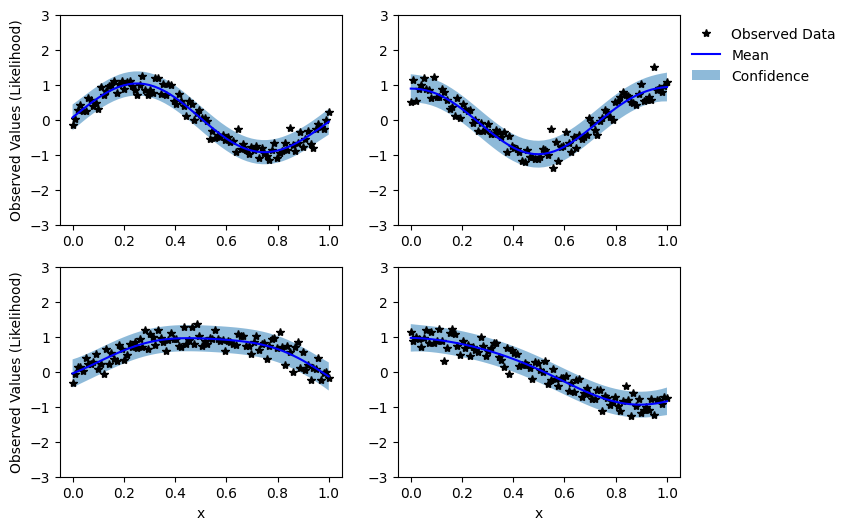

In [5]:
# Set into eval mode
model.eval()
likelihood.eval()

# Initialize plots
f, axes = plt.subplots(2, 2, figsize=(8, 6))

# Make predictions
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_x = torch.linspace(0, 1, 51)
    predictions = likelihood(model(test_x))
    mean = predictions.mean
    lower, upper = predictions.confidence_region()
    
# This contains predictions for all tasks, flattened out
for task, ax in enumerate(axes.flatten()):

    # Plot training data as black stars
    ax.plot(train_x.detach().numpy(), train_y[:, task].detach().numpy(), 'k*')
    # Predictive mean as blue line
    ax.plot(test_x.numpy(), mean[:, task].numpy(), 'b')
    # Shade in confidence 
    ax.fill_between(test_x.numpy(), lower[:, task].numpy(), upper[:, task].numpy(), alpha=0.5)
    ax.set_ylim([-3, 3])
    if task == 1:
        ax.legend(['Observed Data', 'Mean', 'Confidence'], frameon=False, bbox_to_anchor=(1, 1))
    if not task % 2:
        ax.set_ylabel('Observed Values (Likelihood)')
    if task > 1:
        ax.set_xlabel('x')